In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/final_object/"
)
FIG2SAVE = DIR2SAVE.joinpath("figures/forpaper/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad( DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_final_annotations.h5ad"
    ))
adata.shape

(98312, 2000)

In [4]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       75489
Myeloid        17232
B               2116
Plasma          1610
Stromal          786
Endothelial      557
Hepatocyte       437
Mast              85
Name: Annotation_scVI, dtype: int64

In [11]:
adata.obs[["cell_source", "Patient"]].groupby("cell_source").count()

Patient
cell_source         
BCI-Nuclei      5026
Che-Cells      43984
Wu-Cells       49302

In [4]:
len(adata.obs[adata.obs.cell_source.isin(["Wu-Cells"])]["Patient"].unique())

20

In [17]:
len(adata.obs[adata.obs.cell_source.isin(["Wu-Cells", "Che-Cells"])]["Patient"].unique())

26

In [18]:
len(adata.obs[adata.obs.cell_source.isin(["Wu-Cells", "Che-Cells"])]["Sample"].unique())

31

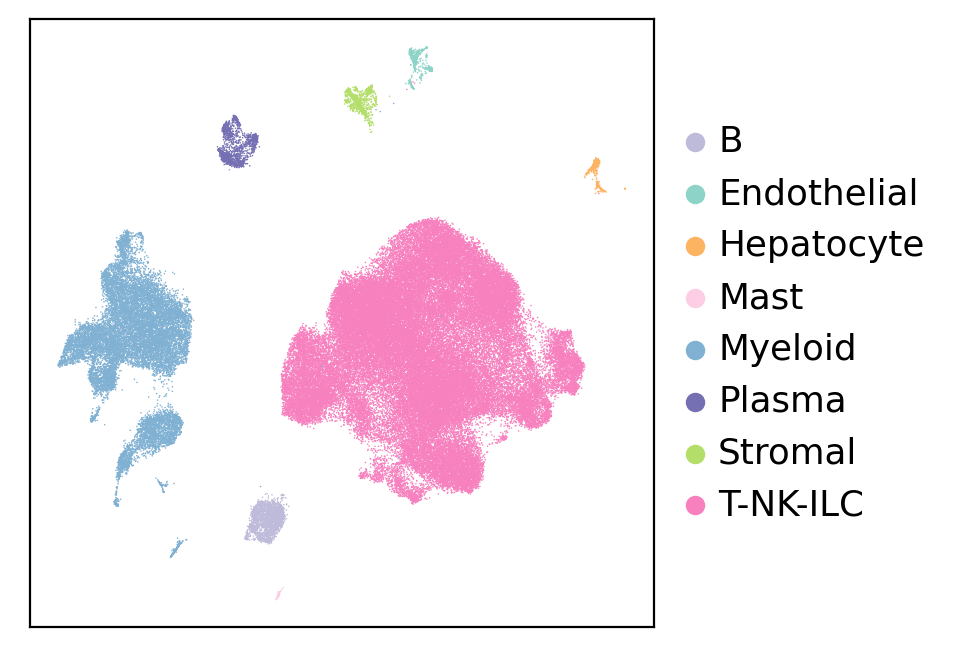

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
sc.pl.umap(adata, color="Annotation_scVI", title="", ax=ax, show=False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation_global.pdf"), bbox_inches='tight', dpi=DPI)

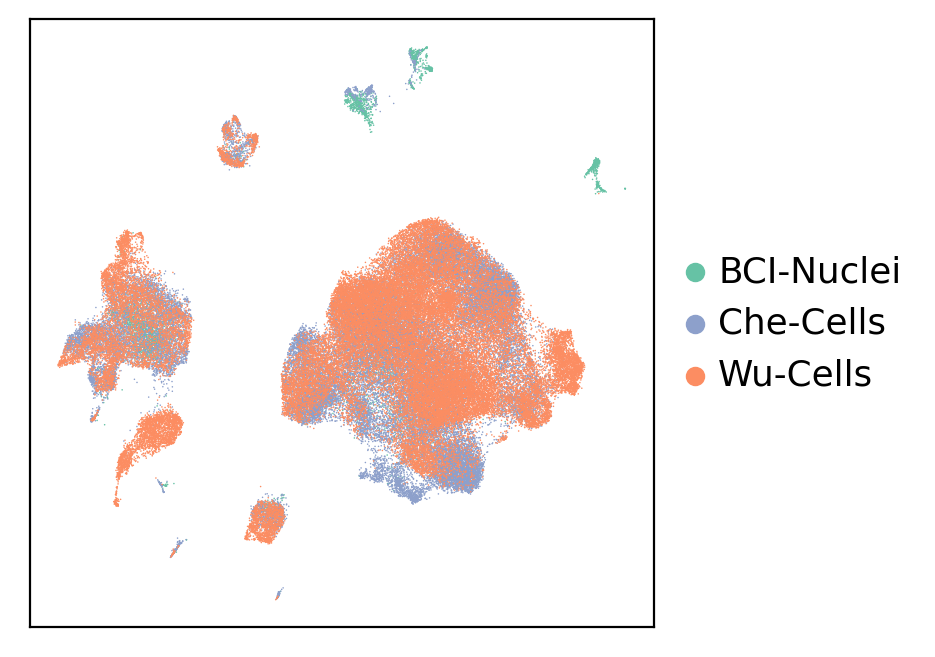

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(adata, color="cell_source", title="", ax=ax, show=False)
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(FIG2SAVE.joinpath("cell_source_global.pdf"), dpi=DPI, bbox_inches="tight")

### plot proportion per cell type

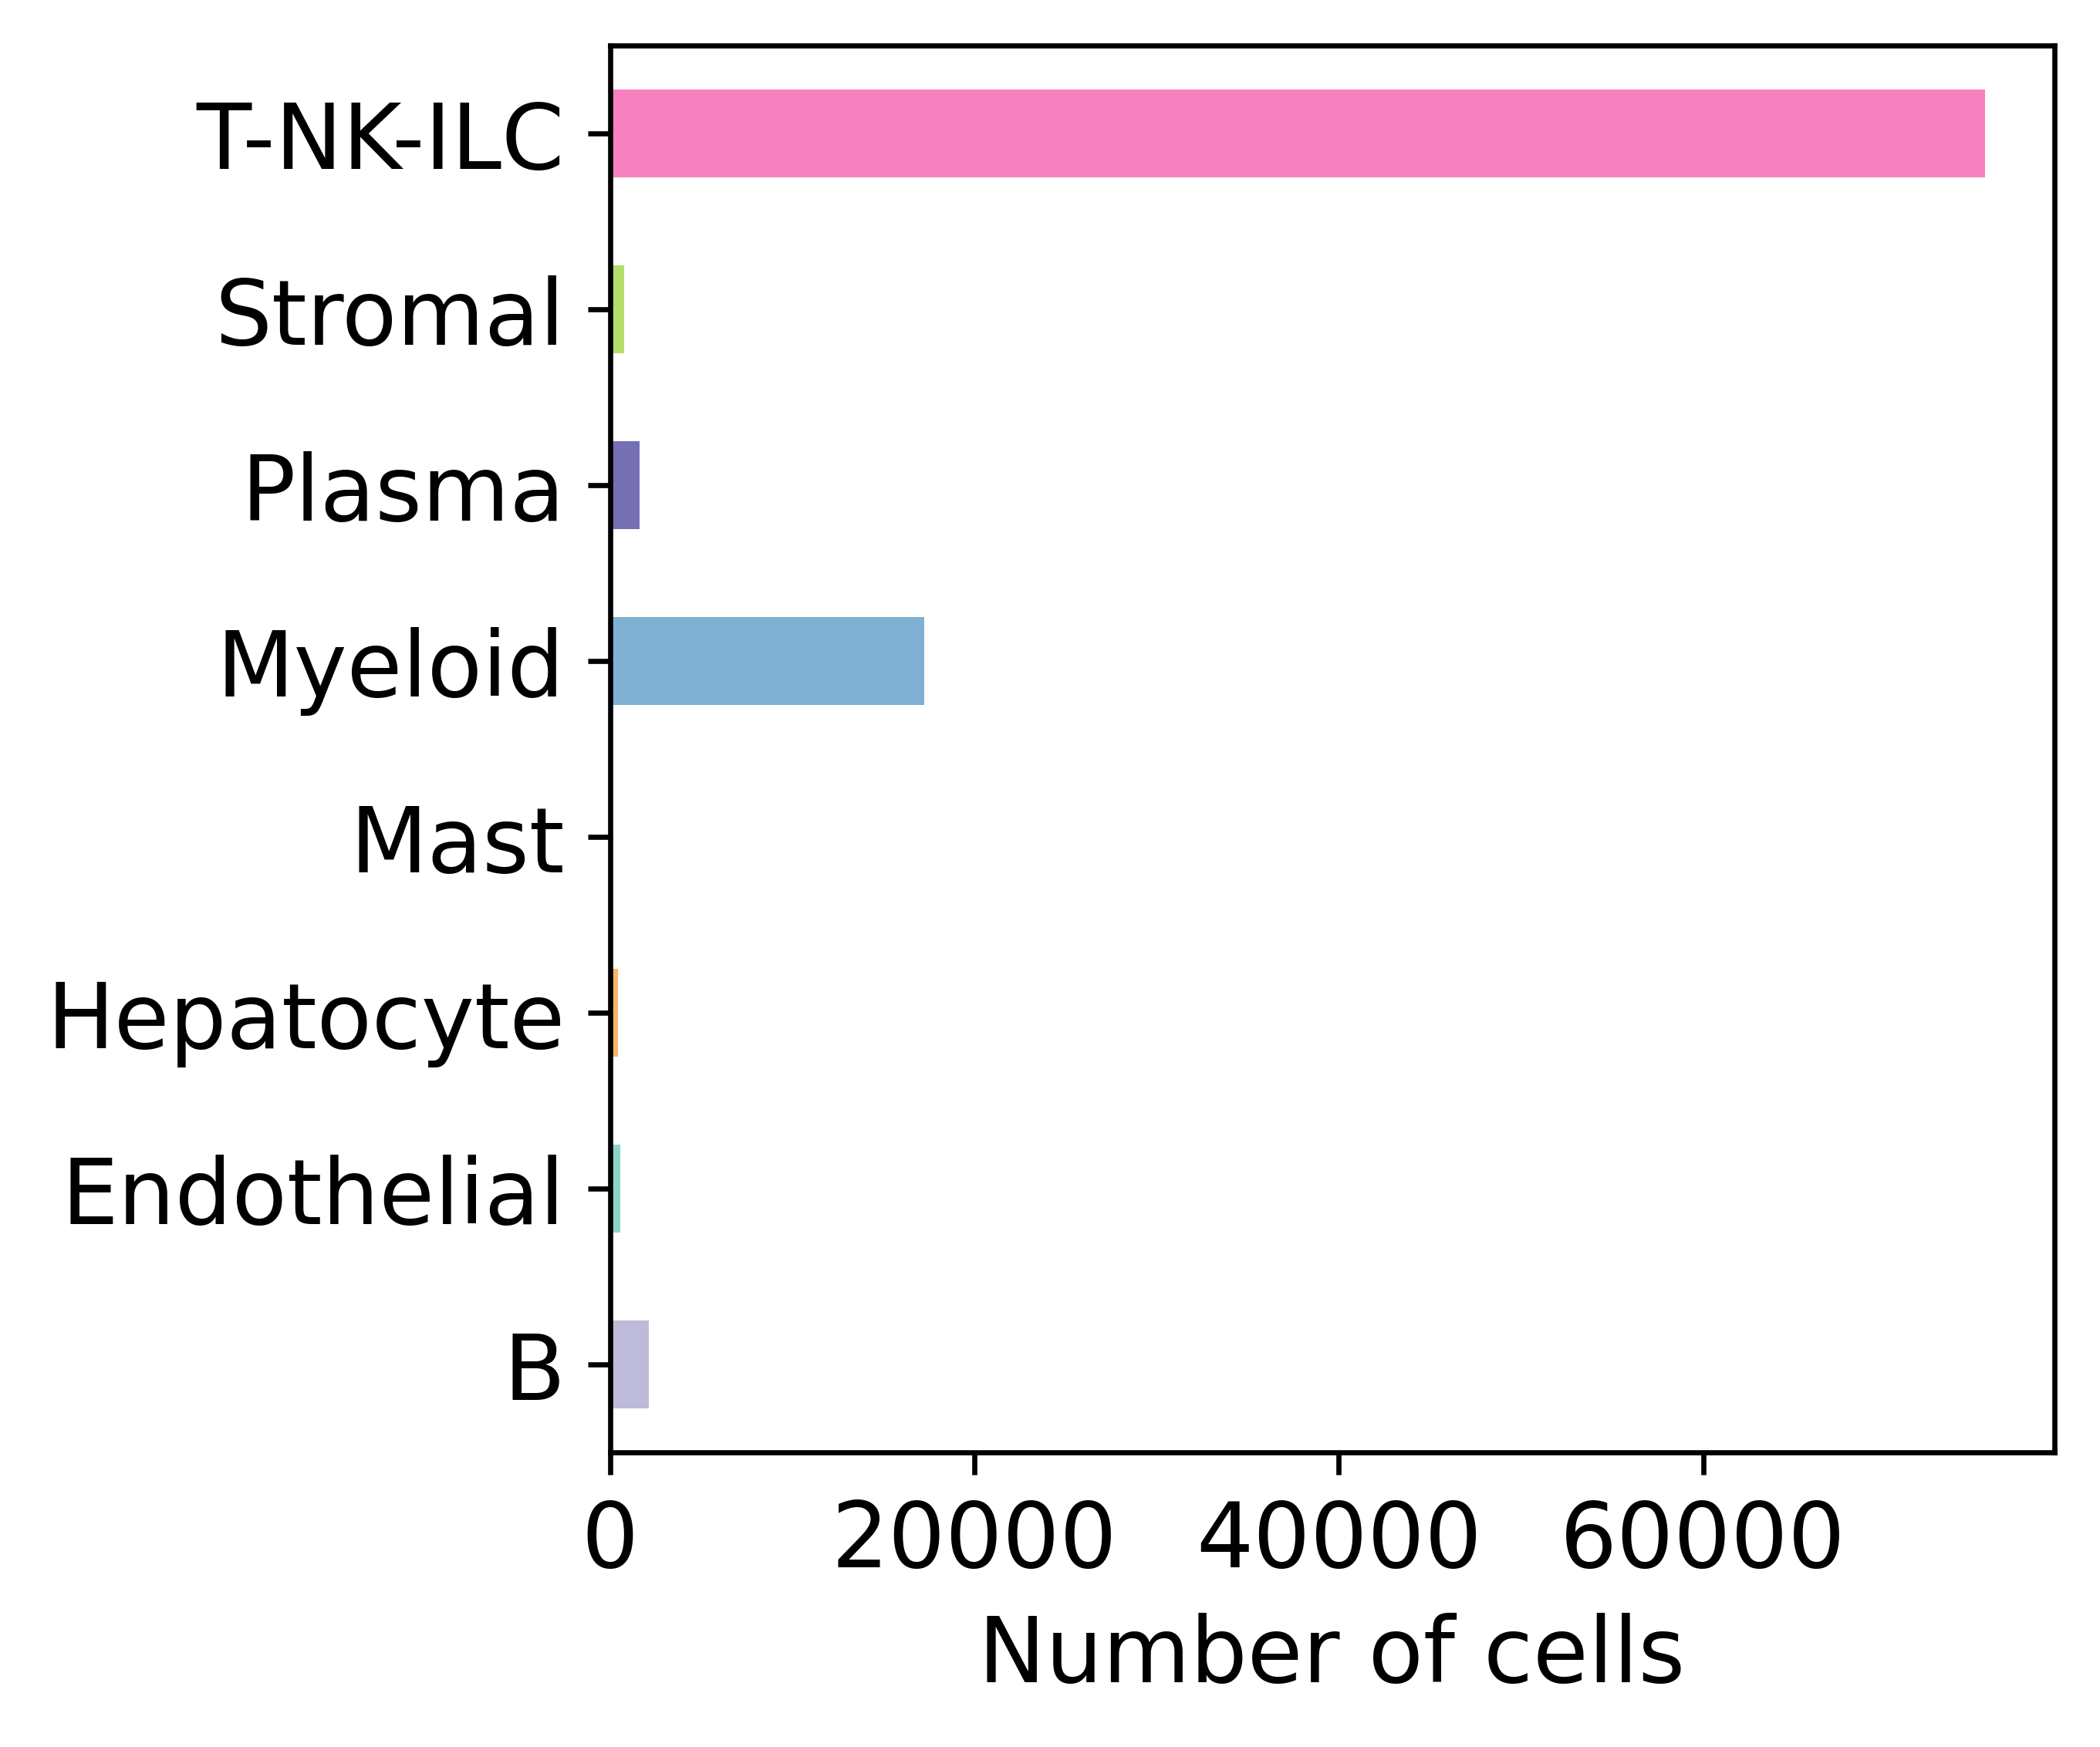

In [6]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_colors"],
    )
)

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI)
adata.obs.groupby("Annotation_scVI").size().plot.barh(color=color_dict.values(), ax=ax)
ax.set_ylabel("")
ax.set_xlabel("Number of cells")
ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd
plt.savefig(FIG2SAVE.joinpath("barplot_nb_cells_celltype.pdf"), bbox_inches='tight')

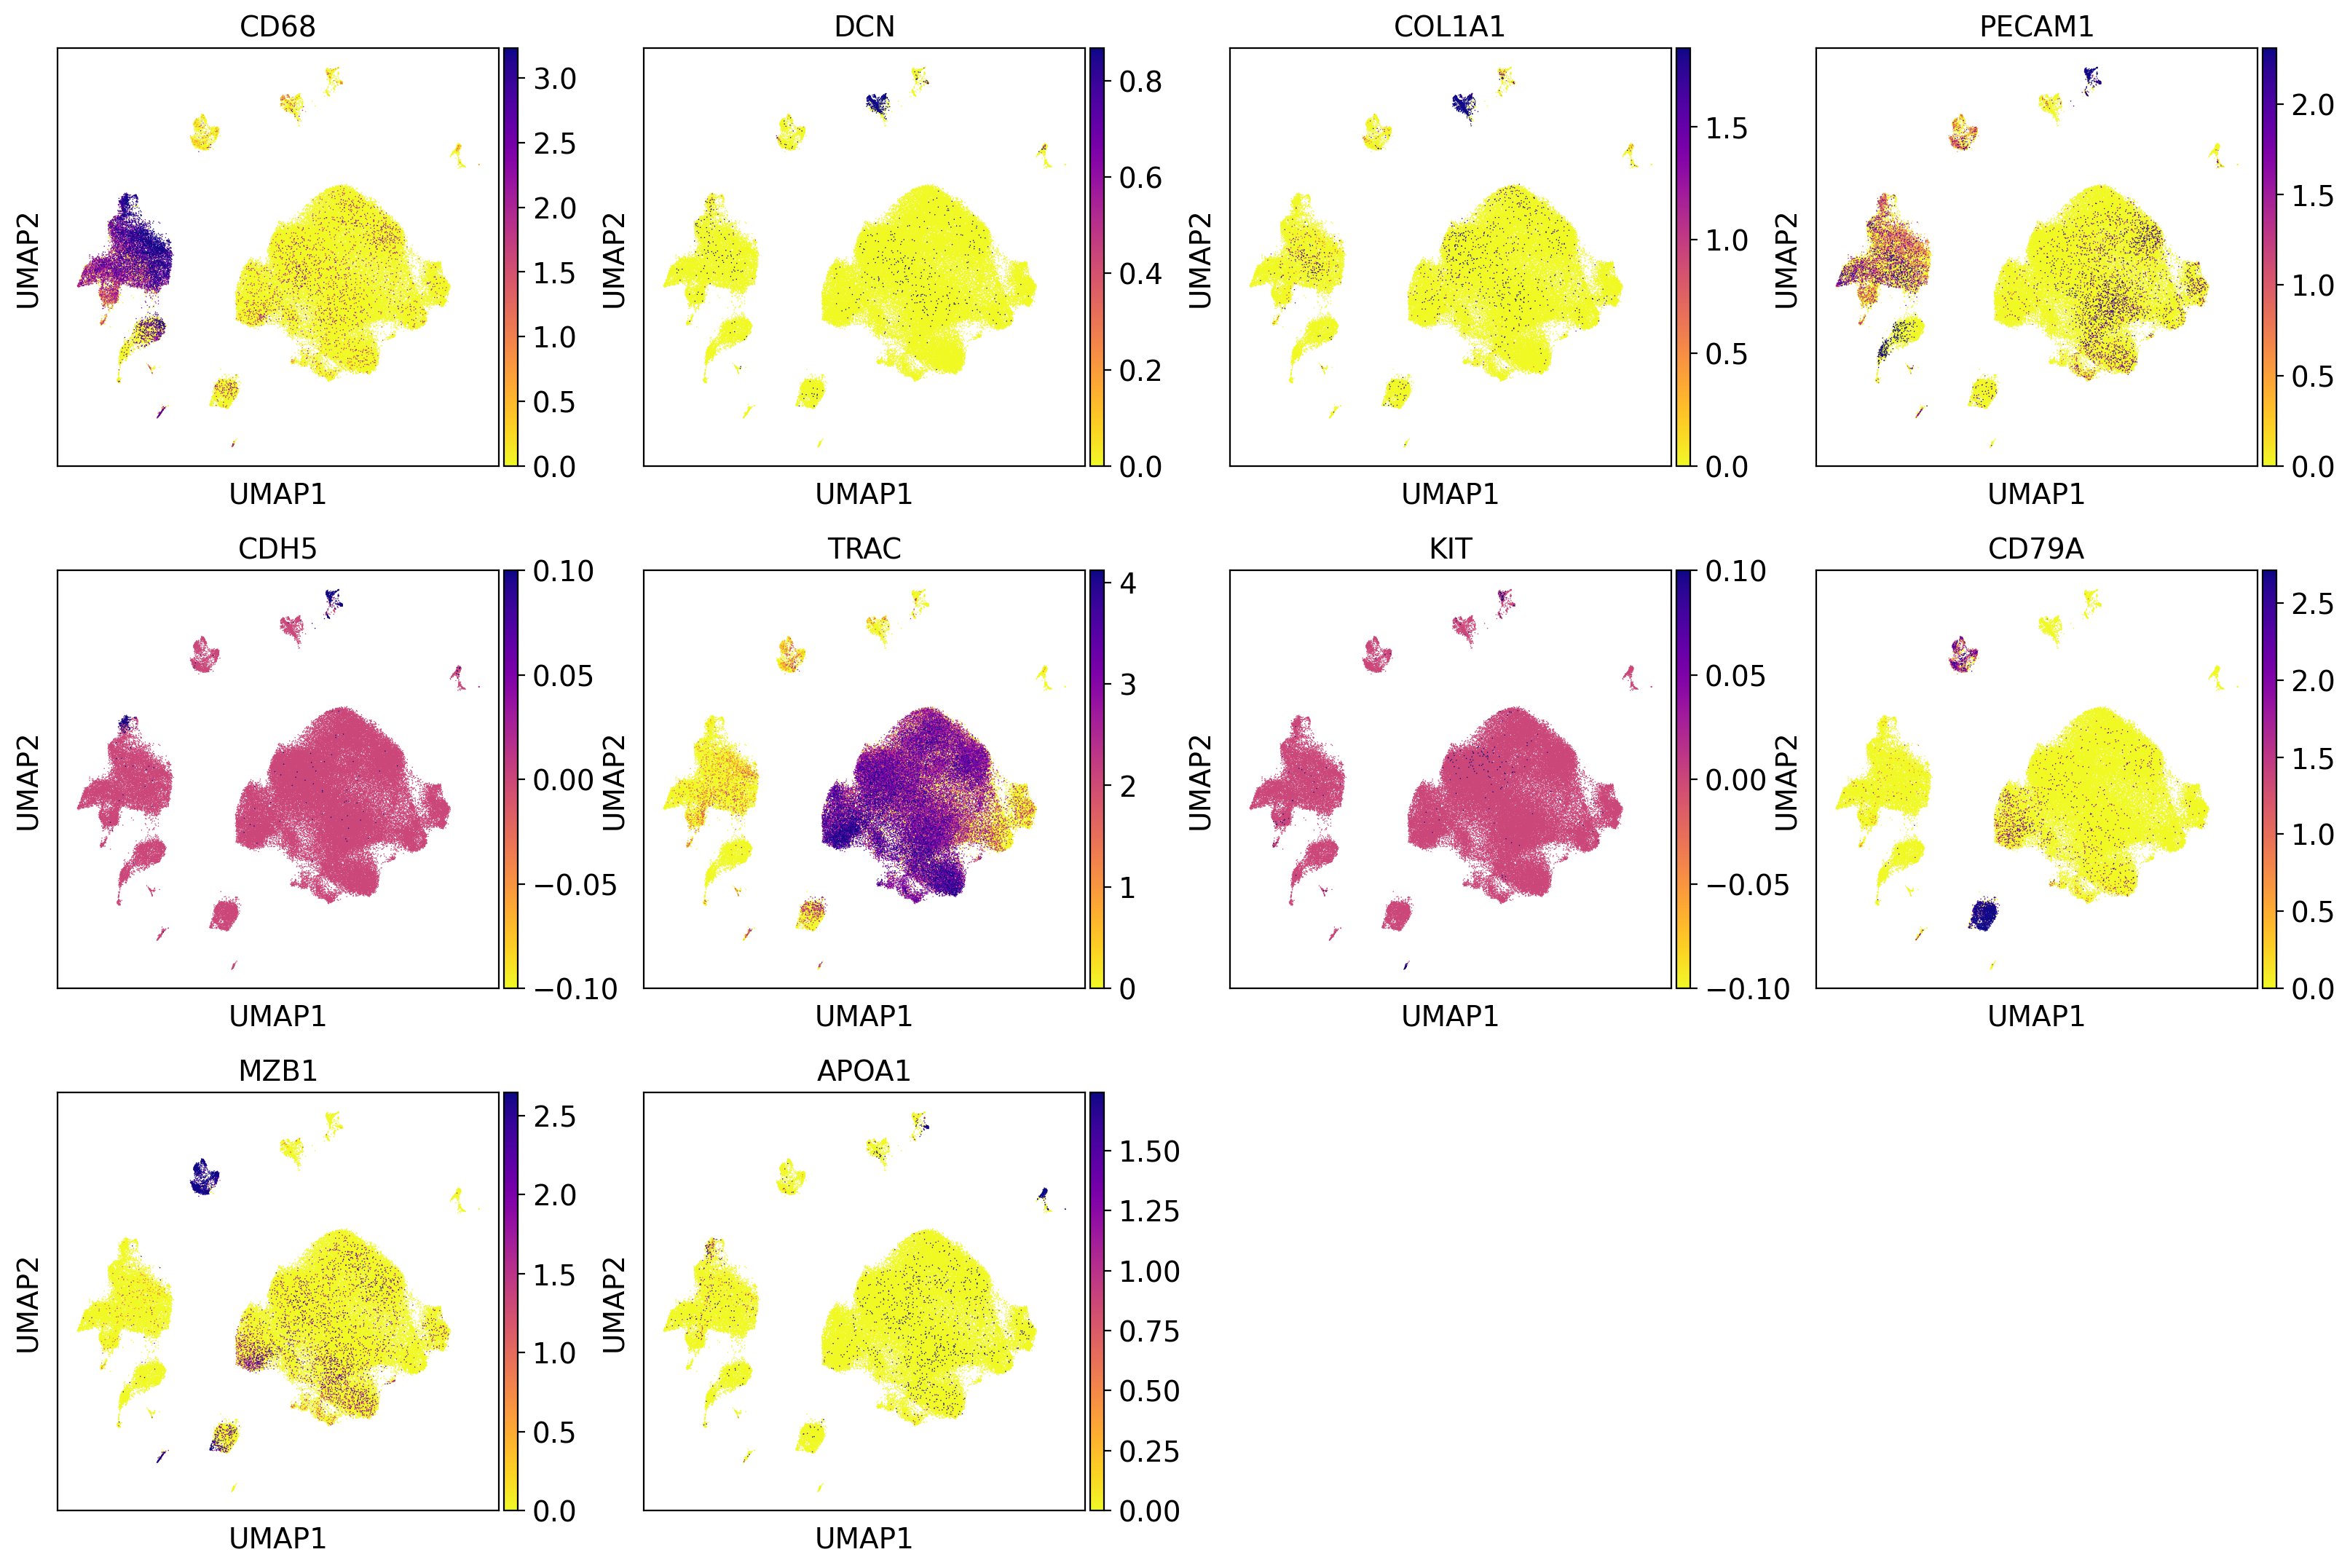

In [7]:
marker_subset = [
    #"EPCAM",
    #"CDH1",
    "CD68",
    "DCN",
    #"VCAM1",
    "COL1A1",
    "PECAM1",
    "CDH5",
    "TRAC",
    "KIT",
    "CD79A",
    "MZB1",
    "APOA1" # hepatocyte
]
sc.pl.umap(
    adata,
    color=marker_subset,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",
    save="general_markers_major_celltypes.pdf",
    show=True,
)

In [8]:
adata.obs.Annotation_scVI.cat.categories

Index(['B', 'Endothelial', 'Hepatocyte', 'Mast', 'Myeloid', 'Plasma',
       'Stromal', 'T-NK-ILC'],
      dtype='object')

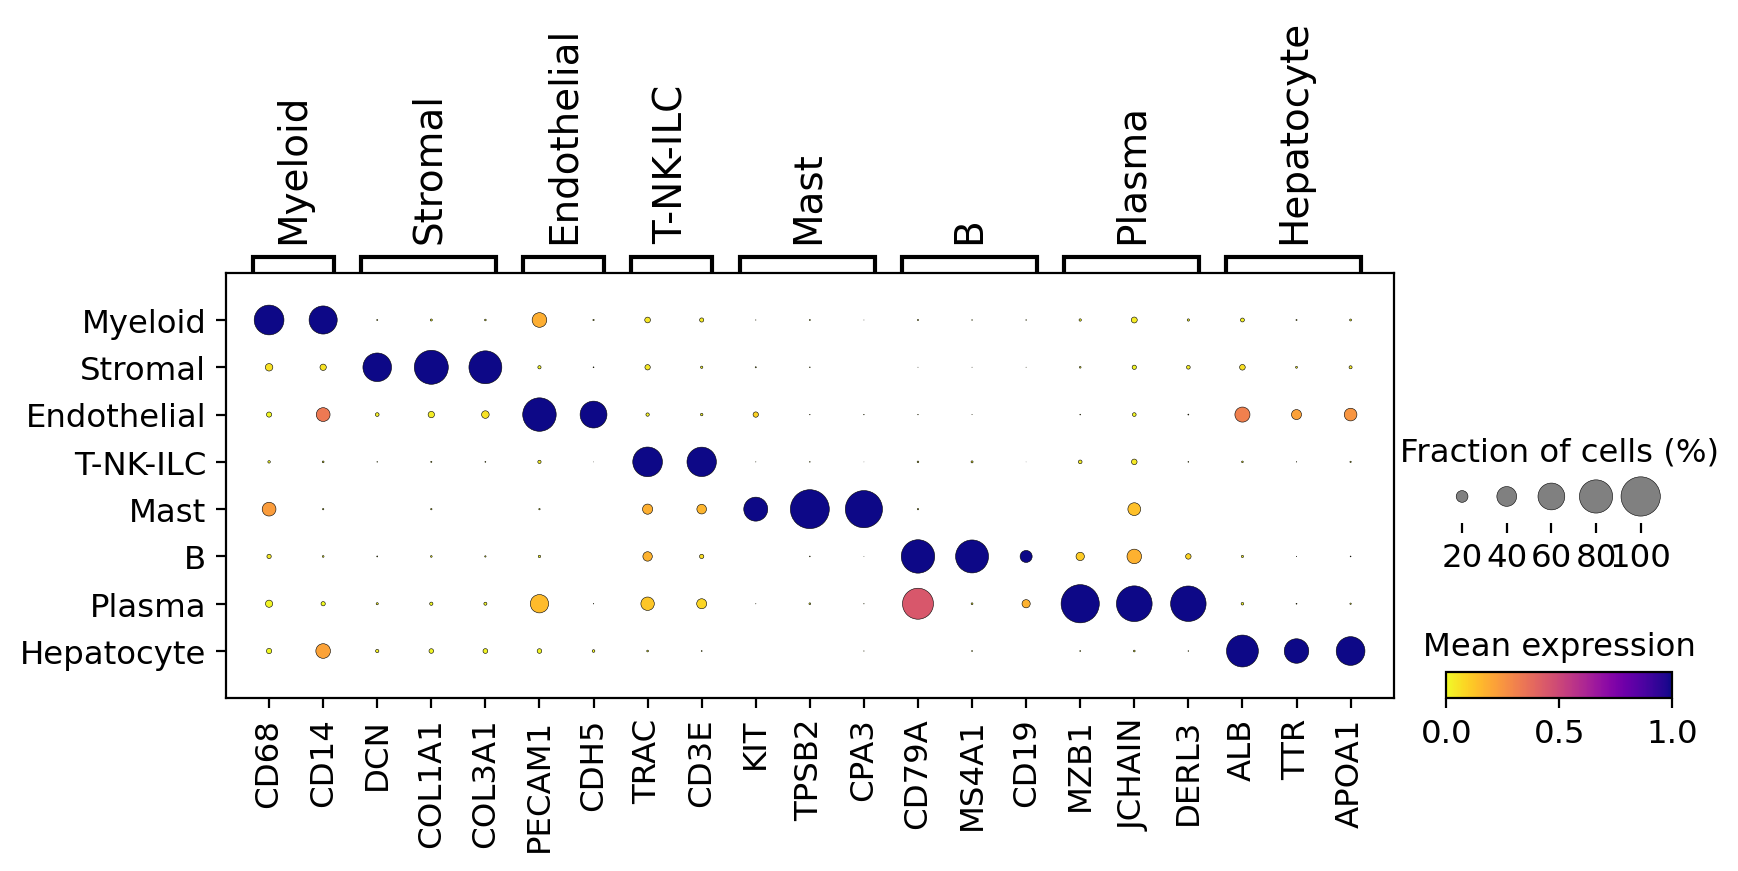

In [9]:
markers_short_list = {
    #"Epithelial": ["EPCAM", "CDH1"],
    "Myeloid": ["CD68", "CD14"],
    "Stromal": ["DCN", "COL1A1","COL3A1"],
    "Endothelial": ["PECAM1", "CDH5"],
    "T-NK-ILC": ["TRAC", "CD3E"],
    "Mast": ["KIT", "TPSB2", "CPA3"], # "GATA2"
    "B": ["CD79A", "MS4A1", "CD19"],
    "Plasma": ["MZB1", "JCHAIN", "DERL3"], # "SDC1",  
    "Hepatocyte": ["ALB", "TTR", "APOA1"],
}

sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI",
    categories_order=[
        "Myeloid",
        "Stromal",
        "Endothelial",
        "T-NK-ILC",
        "Mast",
        "B",
        "Plasma",
        "Hepatocyte"
    ],
    use_raw=True,
    var_names=markers_short_list,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title = "Fraction of cells (%)",
    dendrogram=False,
    save="dotplot_mean_general_short.pdf",
    show=True,
)


### Zscore

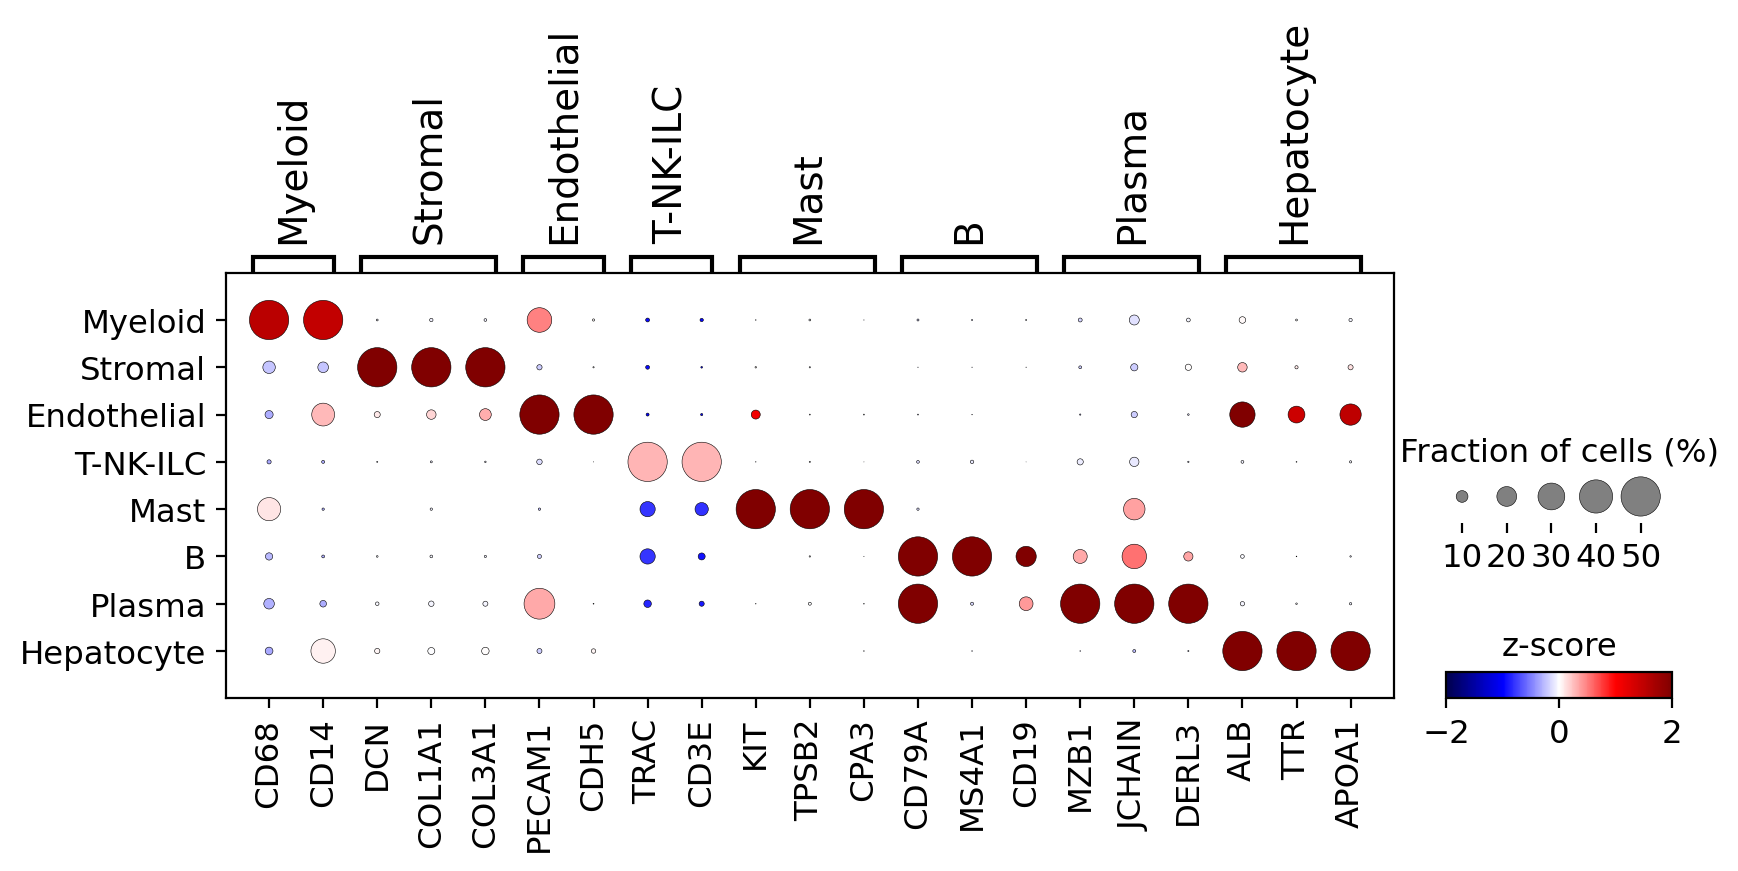

In [10]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers_short_list,
              groupby="Annotation_scVI",
              categories_order=markers_short_list.keys(),
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.5, 
              colorbar_title = "z-score", 
              size_title="Fraction of cells (%)",
             )

In [4]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source      BCI-Nuclei  Che-Cells   Wu-Cells
Annotation_scVI                                  
B                  4.631380  35.207940  60.160681
Endothelial       87.791741  12.208259   0.000000
Hepatocyte       100.000000   0.000000   0.000000
Mast               1.176471  90.588235   8.235294
Myeloid           10.608171  38.329851  51.061978
Plasma             3.975155  50.372671  45.652174
Stromal           69.847328  30.152672   0.000000
T-NK-ILC           2.066526  46.948562  50.984912


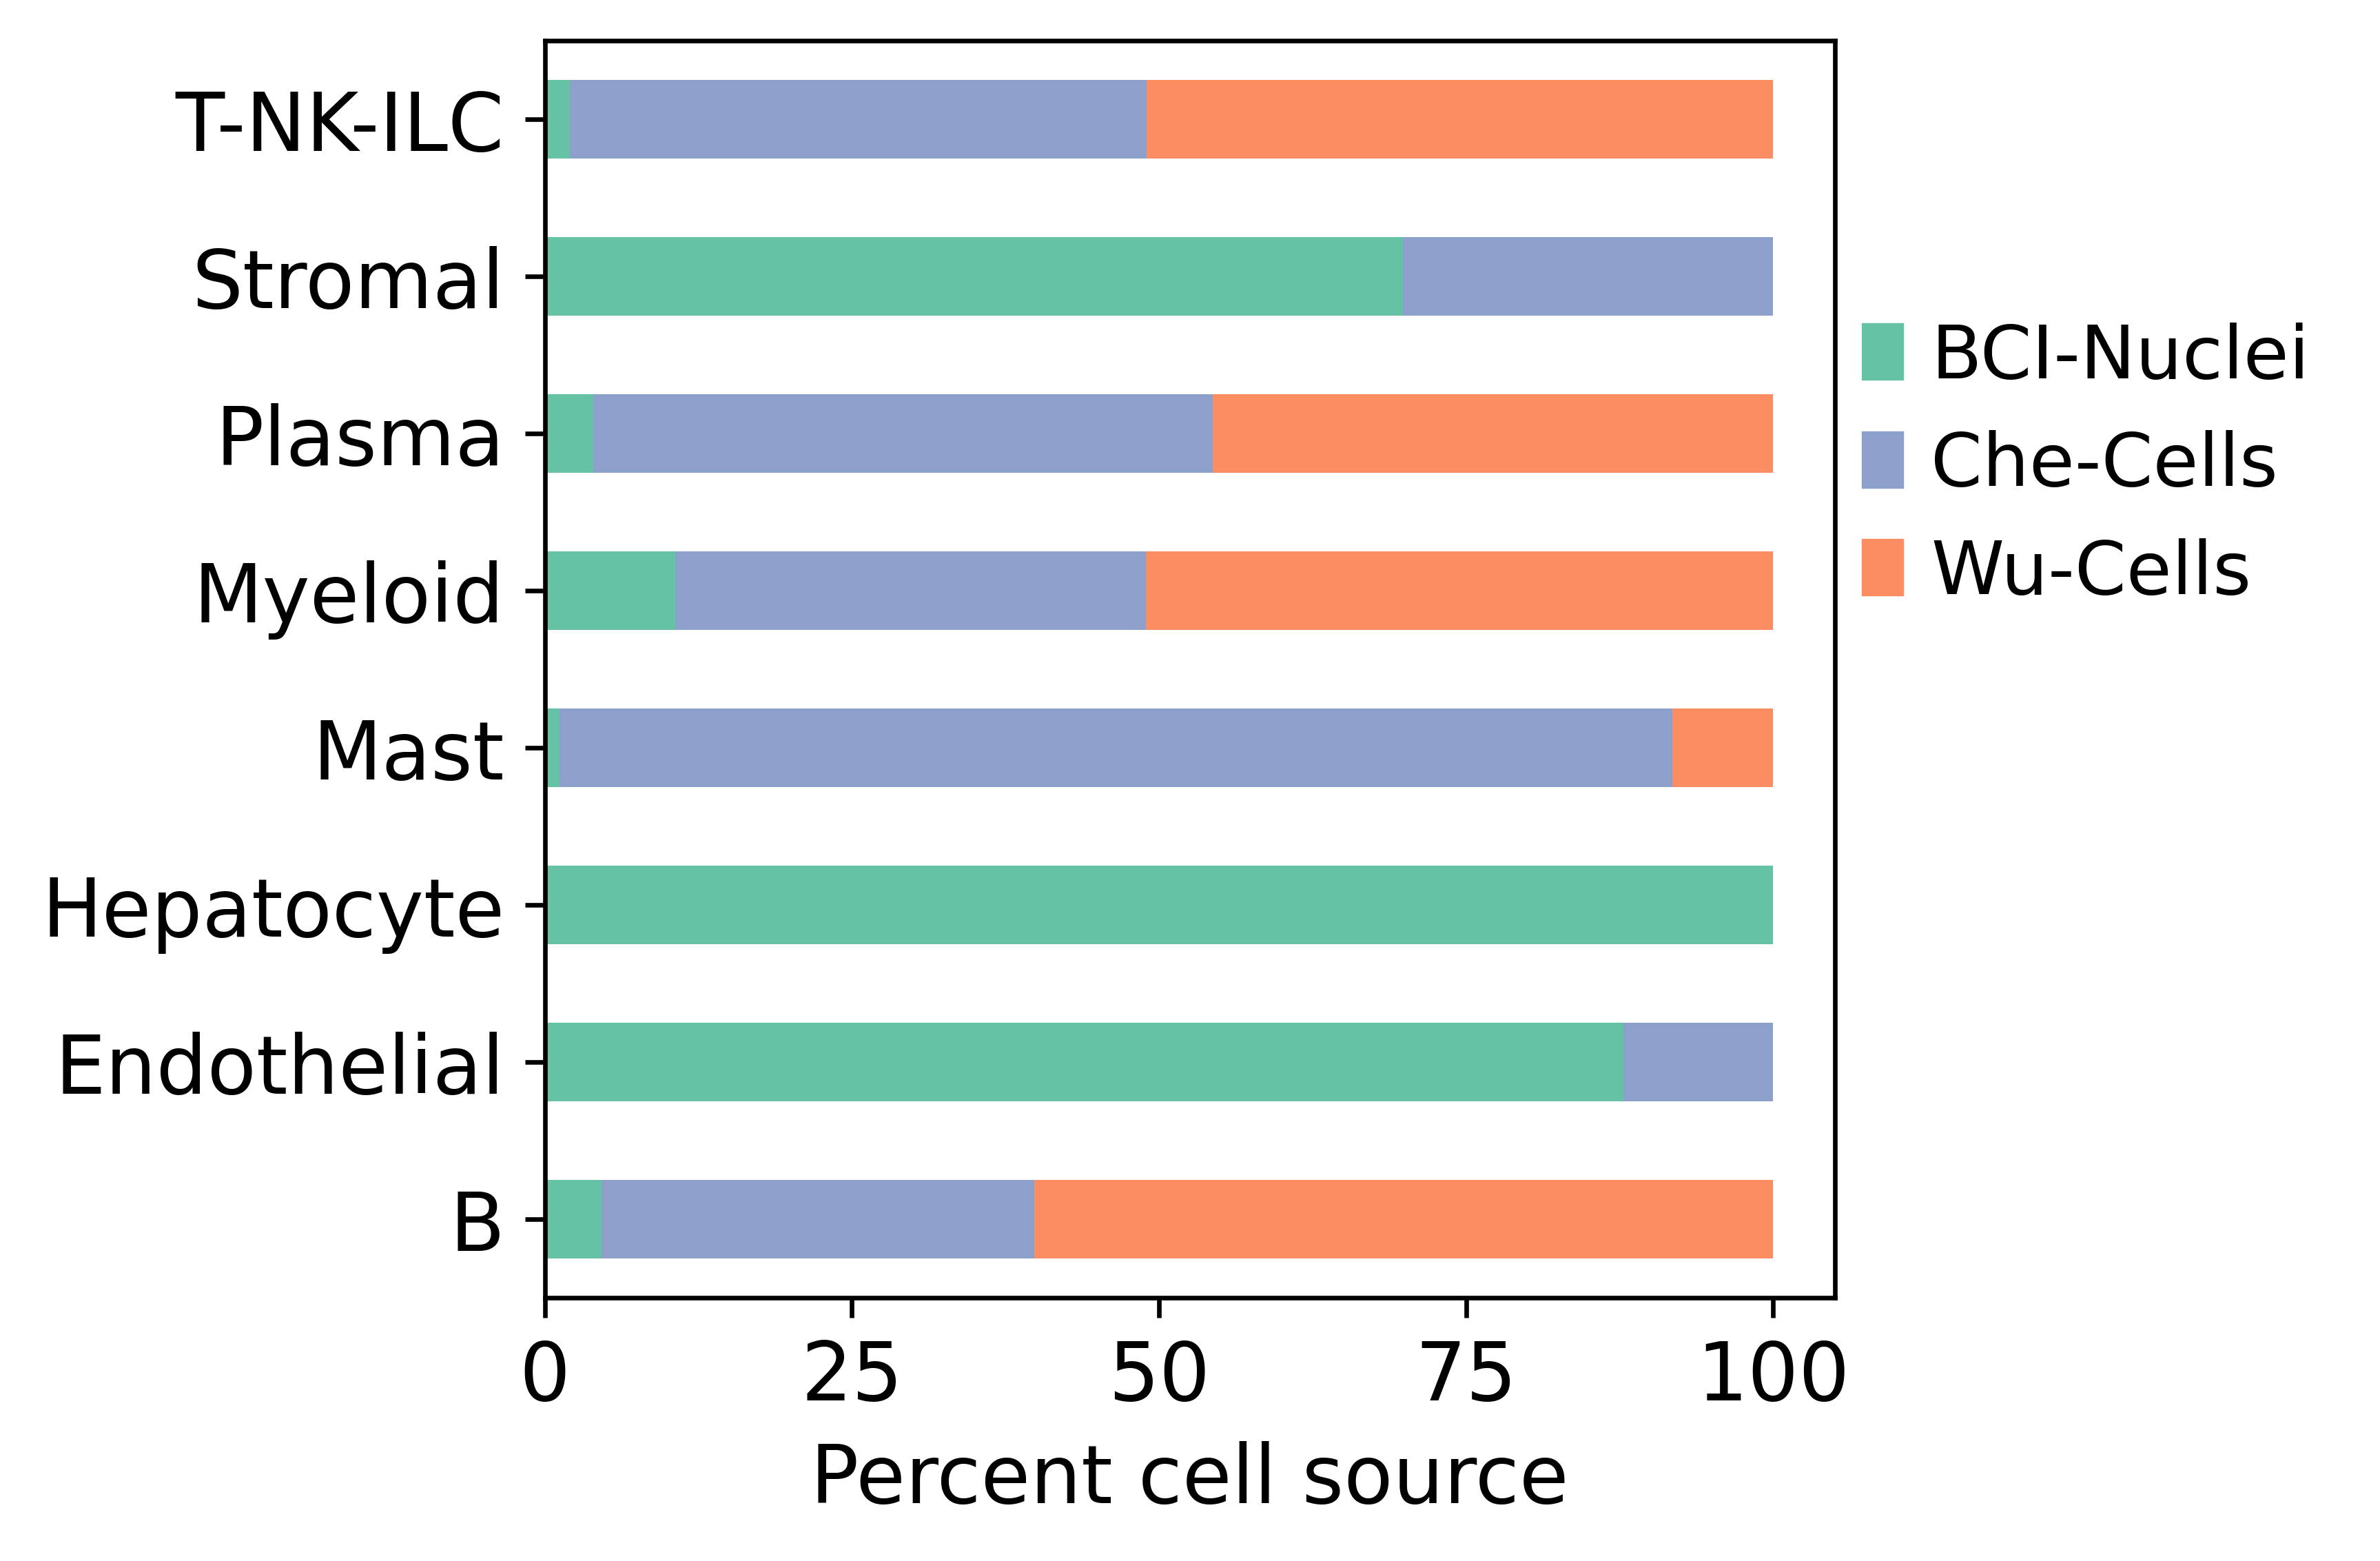

In [12]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI", "cell_source"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

Annotation_scVI         B  Endothelial  Hepatocyte      Mast    Myeloid  \
cell_source                                                               
BCI-Nuclei       1.949861     9.729407    8.694787  0.019897  36.370871   
Che-Cells        1.693798     0.154602    0.000000  0.175064  15.016824   
Wu-Cells         2.582045     0.000000    0.000000  0.014198  17.847146   

Annotation_scVI    Plasma    Stromal   T-NK-ILC  
cell_source                                      
BCI-Nuclei       1.273378  10.923199  31.038599  
Che-Cells        1.843852   0.538832  80.577028  
Wu-Cells         1.490812   0.000000  78.065799  


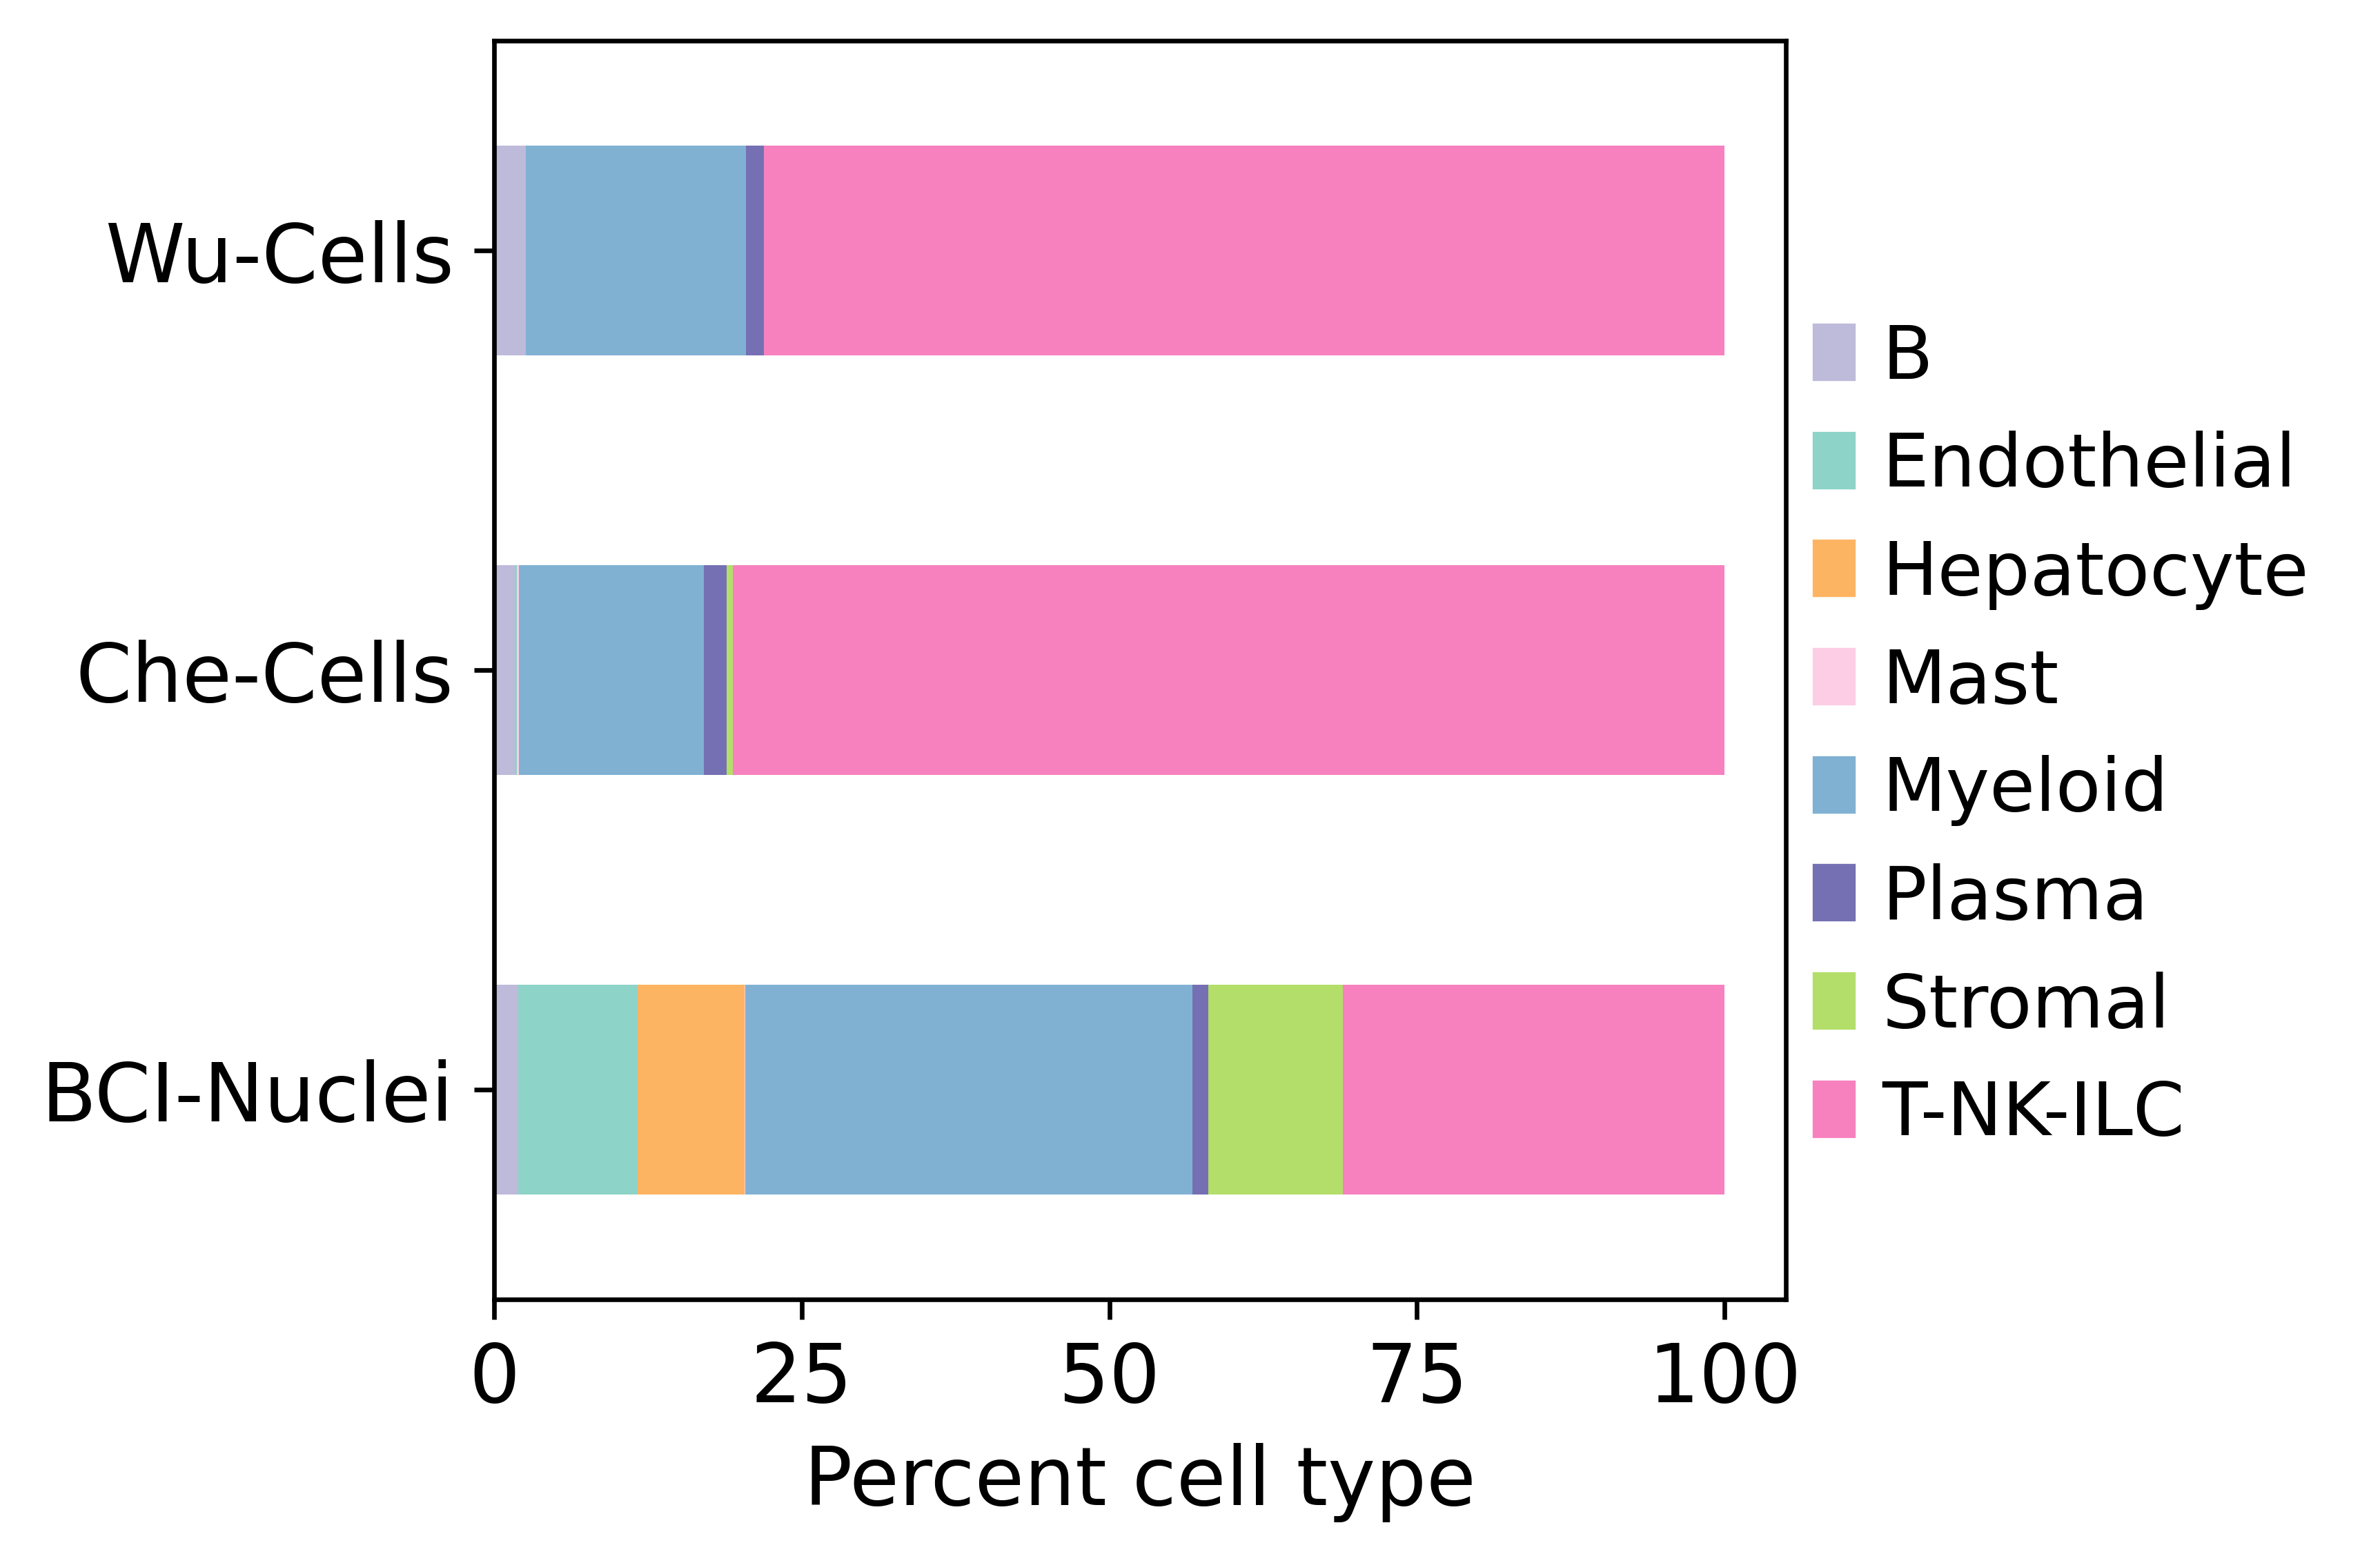

In [5]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["cell_source", "Annotation_scVI"],
    xlabel="Percent cell type",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_type.pdf",
)

In [13]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/final_object/figures/forpaper')

In [14]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       75489
Myeloid        17232
B               2116
Plasma          1610
Stromal          786
Endothelial      557
Hepatocyte       437
Mast              85
Name: Annotation_scVI, dtype: int64

In [15]:
adata.obs["Annotation_scVI_detailed"].cat.categories

Index(['B', 'C1QC Mac', 'C3 iCAF', 'CD4 Tfh', 'CD4 Th', 'CD4 Th HSP',
       'CD4 Th17', 'CD4 Tn', 'CD8 Tem', 'CD8 Tem GZMB', 'CD8 Tem HSP',
       'CD8 Tex', 'Cholangiocyte', 'ECM CAF', 'FCN1 Mono', 'HSP Mono',
       'Hepatocyte', 'IL1B Mac', 'Kupffer', 'Lymphatic endo', 'MAIT', 'Mast',
       'Myeloid cycling', 'Myofibroblast', 'NK1', 'NK2', 'NKT', 'NLRP3 Mac',
       'Neutrophil', 'PLTP LYVE1 Mac', 'Pericyte', 'Plasma', 'SEC', 'SMC',
       'SPP1 Mac', 'Stalk-like endo', 'T cycling', 'Tip-like endo', 'Treg',
       'cDC1', 'cDC2', 'gdT', 'migDC', 'pDC'],
      dtype='object')

In [16]:
celltype_palette = {
    'B': "#BEBADA", 
    'C1QC Mac':  "#80b1d3", 
    'C3 iCAF':  "#41ab5d", 
    'CD4 Tfh': "#1f78b4", 
    'CD4 Th': "#fa9fb5",
    'CD4 Th HSP': "#beaed4",
    'CD4 Th17': "#fdbf6f",
    'CD4 Tn': "#b15928",
    'CD8 Tem': "#e31a1c",
    'CD8 Tem GZMB': "#fc9272",
    'CD8 Tem HSP': "#800026",
    'CD8 Tex': "#ff7f00", 
    'Cholangiocyte': "#ccebc5",
    'ECM CAF': "#fe4fe1", 
    'FCN1 Mono': "#b3de69", 
    'HSP Mono': "#e31a1c",
    'Hepatocyte': "#FDB462", 
    'IL1B Mac': "#fb8072", 
    'Kupffer': "#e78ac3", 
    'Lymphatic endo': "#b2df8a", #"#e78ac3", # to change 
    'MAIT': "#7fc97f", 
    'Mast':"#fccde5",
    'Myeloid cycling': "#ffff99", 
    'Myofibroblast': "#4fe1fe", 
    'NK1': "#1d91c0", 
    'NK2': "#dd3497", 
    'NKT': "#a6cee3", 
    'NLRP3 Mac': "#fdb462",
    'Neutrophil': "#1f78b4",
    'PLTP LYVE1 Mac': "#fccde5", 
    'Pericyte': "#4f8afe", 
    'Plasma': "#7570B3", 
    'SEC': "#fb9a99",  # change with lymphattic endo #d9f0a3
    'SMC': "#e1fe4f",
    'SPP1 Mac': "#8dd3c7", 
    'Stalk-like endo': "#a6cee3", 
    'T cycling': "#ffff99",
    'Tip-like endo': "#1f78b4", 
    'Treg': "#33a02c",
    'cDC1': "#bc80bd", 
    'cDC2': "#bebada", 
    'gdT': "#6a3d9a", 
    'migDC': "#762a83", 
    'pDC': "#fa9fb5"
}

In [17]:
# order keys in palette by object cell types order:
mypalette2show = [celltype_palette[key] for key in adata.obs.Annotation_scVI_detailed.cat.categories]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


Text(0, 0.5, '')

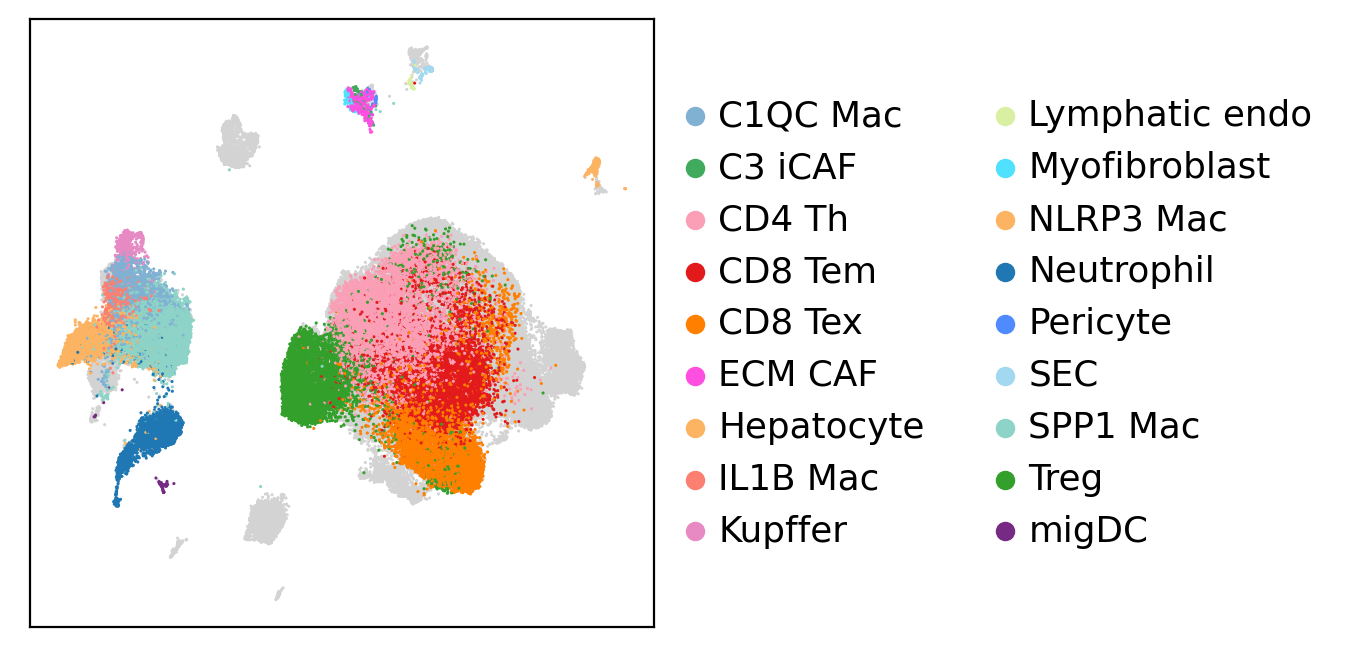

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)

sc.pl.umap(adata, 
           color="Annotation_scVI_detailed", 
           groups=[ "SPP1 Mac", "IL1B Mac", "Neutrophil", "Lymphatic endo", "Myofibroblast", "ECM CAF", 
                   "Pericyte", "C3 iCAF", "C1QC Mac", "Kupffer", "migDC", "Treg", "CD8 Tex",
                   "Hepatocyte", "CD4 Th", "CD8 Tem", "NLRP3 Mac", "SEC", ],
           title="", 
           na_color="lightgray",
           na_in_legend=False,
           ax=ax, 
           palette=mypalette2show,
           size=5,
           show=False)

ax.set_xlabel("")
ax.set_ylabel("")
#plt.savefig(FIG2SAVE.joinpath("Annotation_global.pdf"), bbox_inches='tight', dpi=DPI)

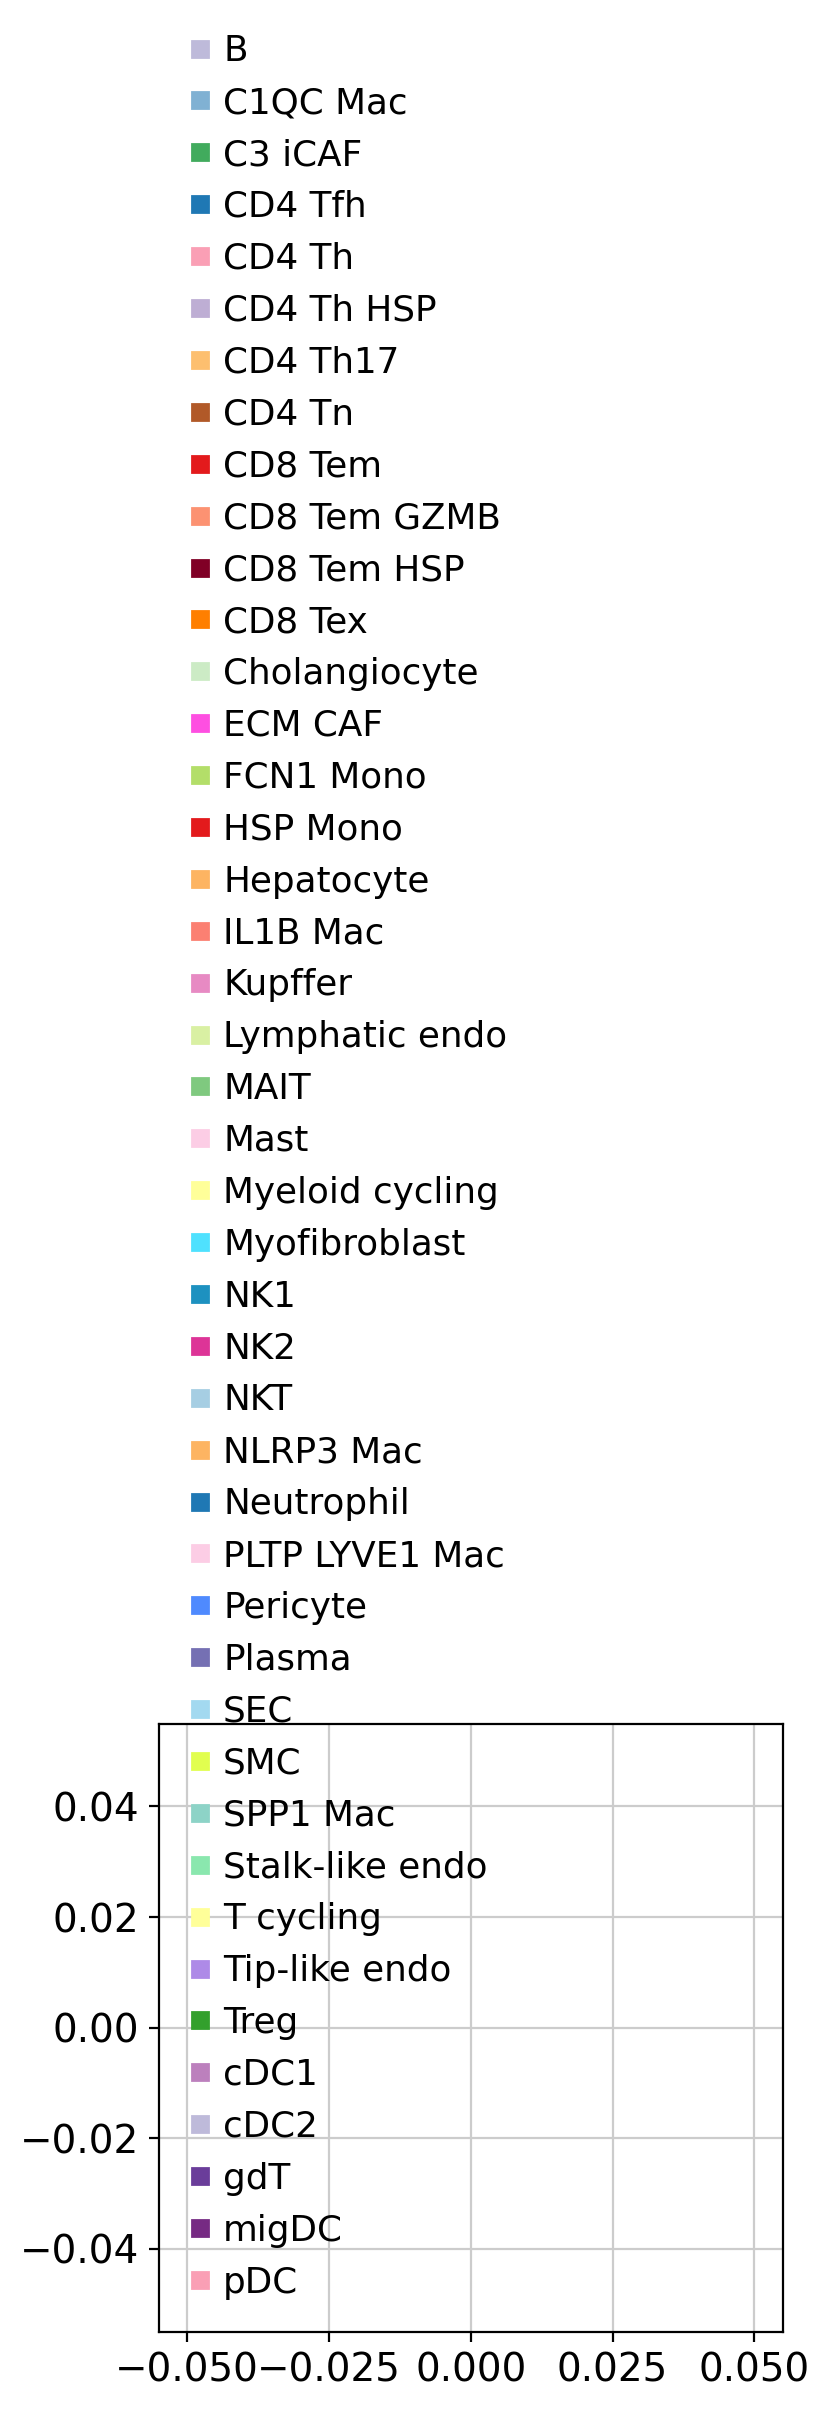

In [19]:
# manually create legend for each major cell type I would do 
import matplotlib.pyplot as plt

colors = celltype_palette
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in celltype_palette.keys()]
labels = colors
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

Text(0, 0.5, '')

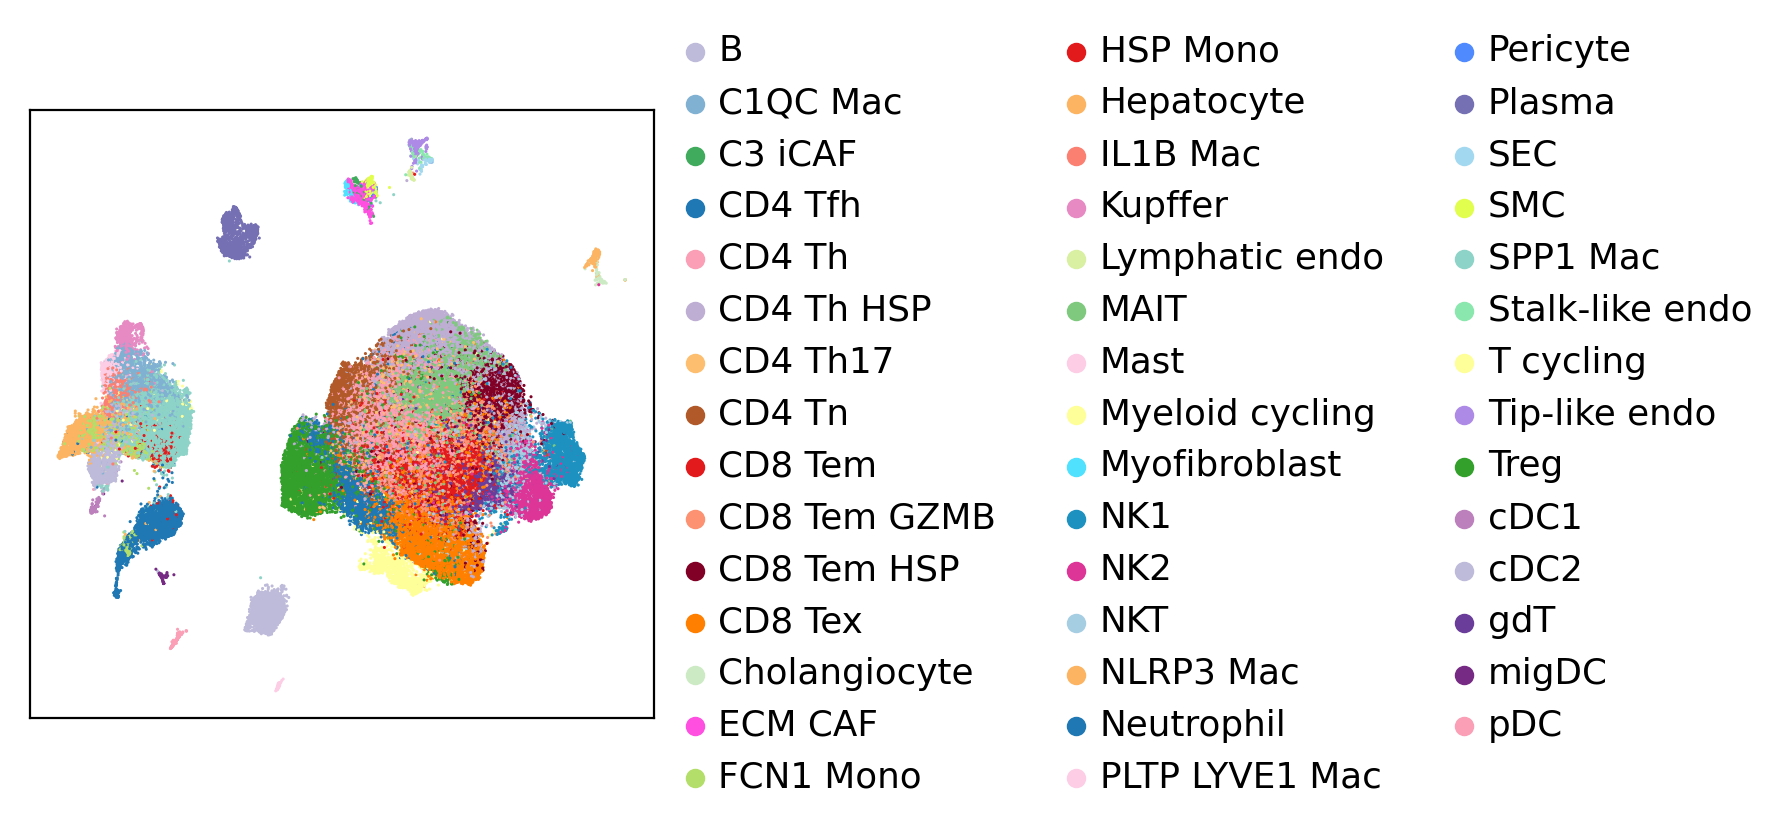

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)

sc.pl.umap(adata, 
           title="", 
           color="Annotation_scVI_detailed", 
           na_color="lightgray",
           na_in_legend=False,
           ax=ax, 
           palette=mypalette2show,
           size=5,
           show=False)

ax.set_xlabel("")
ax.set_ylabel("")
#plt.savefig(FIG2SAVE.joinpath("Annotation_global.pdf"), bbox_inches='tight', dpi=DPI)

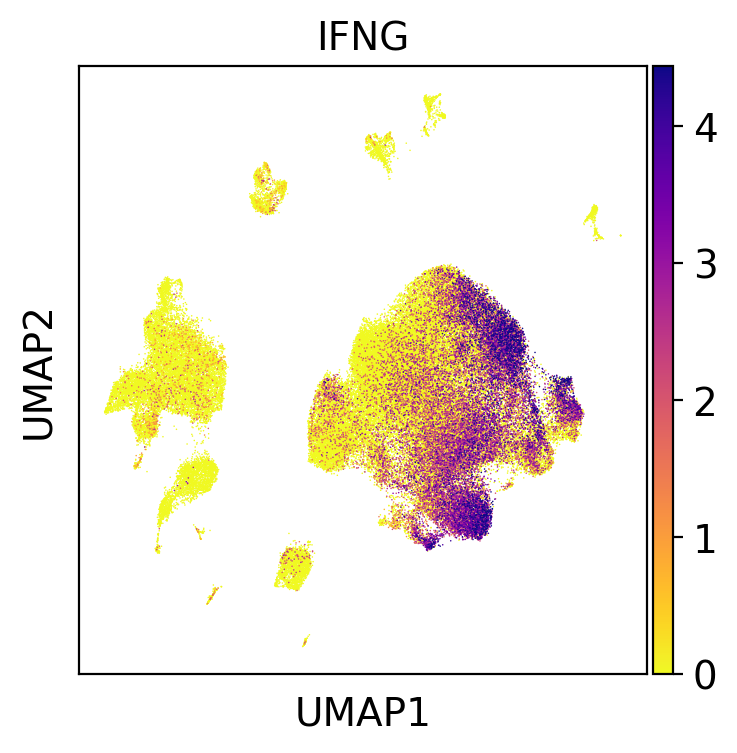

In [21]:
sc.pl.umap(
    adata,
    color=["IFNG"],
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",
    show=True,
)

### Plot therapy umap

In [22]:
# change to Naive vs Treated
adata.obs["Therapy"] = np.where(adata.obs["Therapy"]=="naive", "Naive", "Treated")

# need to update treatment info for our samples

therapy_dict = {
    "CRC01_LM":"Treated",
    "CRC02_LM":"Treated",
    "CRC03_LM":"Treated",
    "CRC04_LM":"Treated",
    "CRC05_LM":"Naive",
    "CRC06_LM":"Naive",
    "CRC07_LM":"Naive",
    "CRC08_LM":"Naive",
    "CRC09_LM":"Naive",
    "CRC10_LM":"Naive",
    "CRC11_LM":"Naive",
    "CRC12_LM":"Naive",
    "CRC13_LM":"Treated",
    "CRC14_LM":"Treated",
    "CRC15_LM":"Treated"    
}

adata.obs["Therapy_updated"] = adata.obs["Sample"].map(therapy_dict)
adata.obs["Therapy_updated"] = np.where(adata.obs["Therapy_updated"].isna(), adata.obs["Therapy"], adata.obs["Therapy_updated"])

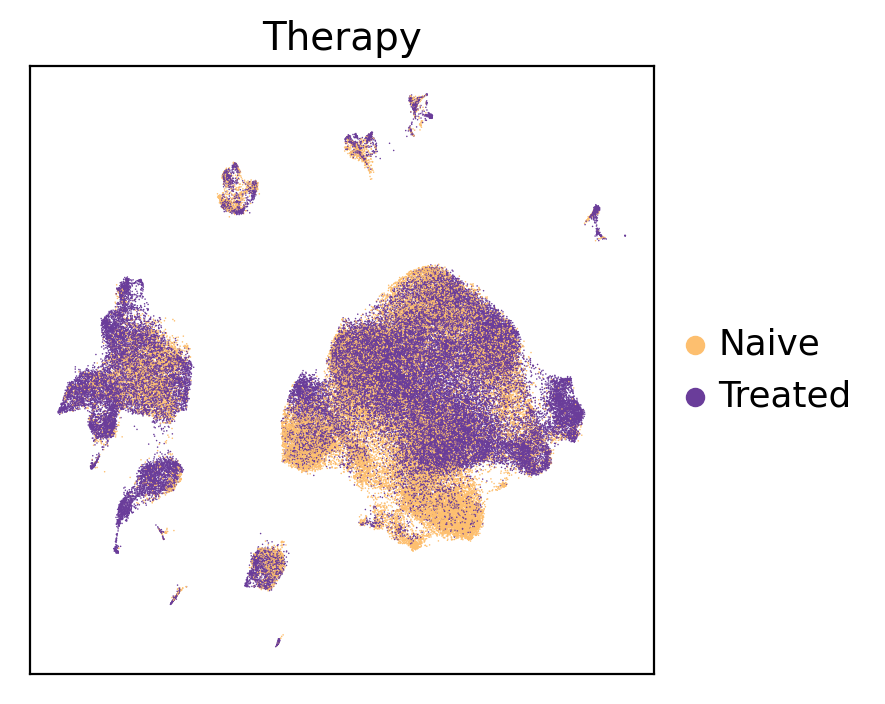

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(adata, color="Therapy_updated", palette=["#fdbf6f","#6a3d9a"], 
           #save="CRCLM_cancerCells_therapy.pdf",
           ax=ax,
           show=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Therapy")
plt.savefig(FIG2SAVE.joinpath("CRCLM_TME_therapy.pdf"), bbox_inches='tight', dpi=DPI)